# Verdict Analysis
Analysis about the general content of verdicts. This is not directly linked to the GR, and should just give some general information about the dataset and how it can be used for other research.

In [1]:
%matplotlib inline

import json
import io
import os
from pathlib import Path

from wordcloud import WordCloud
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

DATA_PATH = Path("..")/".."/"data"/"dataset"

Structure of verdicts:

`{
    "id": str, 
    "date": str, # Format: YYYY-MM-DD
    "court": str, # Format: [type] [place] 
    "normchain": List[str],
    "norms": Dict[placeholder, str], 
    "inst": List[str], # Contains the ids of the previous instances
    "keywords": List[str],
    "title": List[str],
    "guiding_principle": List[List[str]], 
    "tenor": List[str],
    "facts": List[str],
    "reasoning": List[str]
}`

In [2]:
ids = []
dates = []
courts = []
normchains = []
norms = []
insts = []
keywords = []
total = len(os.listdir(DATA_PATH))
for file in tqdm(os.listdir(DATA_PATH)):
    with io.open(DATA_PATH/file, "r", encoding="utf-8") as f:
        verdict = json.load(f)
    ids.append(verdict["id"])
    dates.append(verdict["date"])
    courts.append(verdict["court"])
    normchains.append(verdict["normchain"])
    norms.append(verdict["norms"])
    insts.append(verdict["inst"])
    keywords.append(verdict["keywords"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100018/100018 [00:24<00:00, 4091.89it/s]


### ID Analysis

In [3]:
chars = []
for i in ids:
    split = i.split()
    for part in split:
        if part.isalpha():
            chars.append(part)
            break

In [4]:
wordcloud = WordCloud(background_color="white", 
                      prefer_horizontal=1.0,
                      repeat=False,
                      width=4000,
                      height=4000)
wordcloud.generate(" ".join(chars))

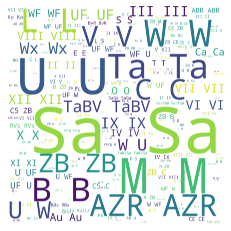

In [5]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("ids.png")
plt.show()

## Date Analysis

In [6]:
from datetime import datetime
from collections import Counter

In [7]:
dates_timestamp = list(map(lambda date: datetime.strptime(date, "%Y-%m-%d"), dates))
print("Earliest:", min(dates), "; Latest:", max(dates))

Earliest: 0014-12-23 ; Latest: 2020-10-15


In [8]:
# Remove smallest date, as this is some parsing error year = 0014
dates_timestamp = sorted(dates_timestamp)[1:]

In [9]:
date_count = Counter(map(lambda x: datetime(x.year, x.month, 1), dates_timestamp))

In [10]:
months = np.array(list(map(lambda x: x[0], date_count.most_common())))
month_counts = np.array(list(map(lambda x: x[1], date_count.most_common())))

Text(0.5, 1.0, 'Verdict Dates')

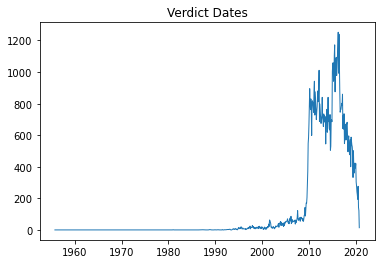

In [11]:
ax = sns.lineplot(x=months, y=month_counts, estimator=None, linewidth=1, palette="hsl")
ax.set_title("Verdict Dates")

## Court Analysis

In [12]:
court_type = list(map(lambda x: x.split()[0], courts))
court_location = list(map(lambda x: x.split()[1:], courts))

In [13]:
court_type_counter = Counter(court_type)
court_type_type = np.array(list(map(lambda x: x[0], court_type_counter.most_common())))
court_type_count = np.array(list(map(lambda x: x[1], court_type_counter.most_common())))

In [14]:
court_type_counter.most_common(20)

[('OLG', 17673),
 ('VG', 12048),
 ('BGH', 8233),
 ('FG', 7194),
 ('LAG', 7151),
 ('VGH', 6953),
 ('BFH', 6463),
 ('Landesarbeitsgericht', 5979),
 ('Oberlandesgericht', 4272),
 ('Oberverwaltungsgericht', 3131),
 ('Verwaltungsgericht', 2502),
 ('BAG', 2380),
 ('LSG', 1890),
 ('Hessisches', 1802),
 ('BVerwG', 1749),
 ('LG', 1713),
 ('Landgericht', 1355),
 ('KG', 1249),
 ('SG', 852),
 ('Niedersächsisches', 755)]

Text(0.5, 1.0, 'Courts')

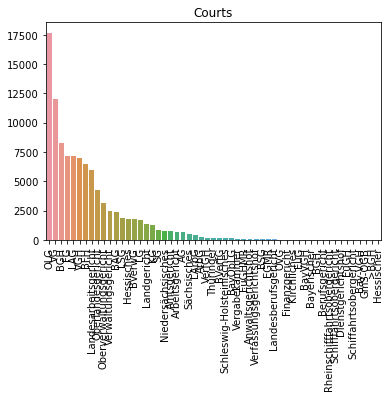

In [15]:
ax = sns.barplot(x=court_type_type, y=court_type_count)
ax.set_xticklabels(court_type_type, rotation=90)
ax.set_title("Courts")

In [16]:
# Can we do a location plot on a Germany map?

## Instances Analysis

In [17]:
insts_length = np.array(list(map(lambda x: len(x), insts)))
print("Min:", insts_length.min(), "; Max:", insts_length.max())

Min: 0 ; Max: 28


Text(0.5, 1.0, 'Number of previous instances')

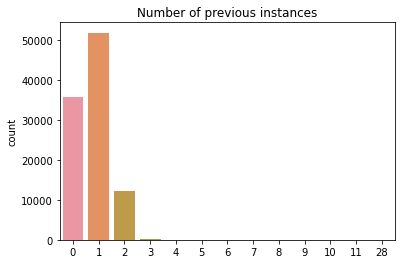

In [18]:
ax = sns.countplot(x=insts_length)
ax.set_title("Number of previous instances")

## Norm Analysis
ATTENTION: The norms are not necessarily unique!

In [21]:
num_norms = list(map(lambda x: len(x), norms))

Text(0.5, 0, 'Referenced Norms')

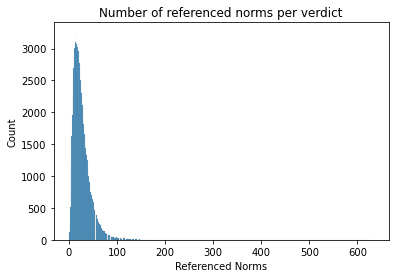

In [23]:
ax = sns.histplot(num_norms)
ax.set_title("Number of referenced norms per verdict")
ax.set_xlabel("Referenced Norms")

In [24]:
print("Min:", min(num_norms), "; Max:", max(num_norms), "; Average:", sum(num_norms)/len(num_norms))

Min: 0 ; Max: 633 ; Average: 26.817812793697133


## Normchain Analysis

In [26]:
replaced_norms = list(map(lambda x: list(map(lambda y: x[0][y],x[1])),zip(norms, normchains)))

In [28]:
general_norms = []
for full_norms in replaced_norms:
    for n in full_norms:
        split = n.split()
        for s in split:
            if s.isalpha():
                general_norms.append(s)
                break

In [29]:
wordcloud = WordCloud(background_color="white", 
                      prefer_horizontal=1.0,
                      repeat=False,
                      width=4000,
                      height=4000)
wordcloud.generate(" ".join(general_norms))

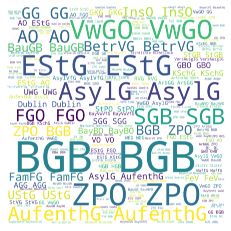

In [30]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("norms.png")
plt.show()

In [32]:
norm_chain_counter = Counter(general_norms)
norm_chain_counter.most_common(20)

[('BGB', 51599),
 ('ZPO', 26996),
 ('VwGO', 20131),
 ('EStG', 18213),
 ('AsylG', 13641),
 ('GG', 12712),
 ('AufenthG', 11402),
 ('SGB', 10858),
 ('AO', 10454),
 ('FGO', 9451),
 ('BetrVG', 6020),
 ('InsO', 5029),
 ('FamFG', 5027),
 ('BauGB', 4744),
 ('UStG', 4606),
 ('KSchG', 3483),
 ('GKG', 3149),
 ('BayBO', 3142),
 ('RVG', 2768),
 ('GBO', 2765)]

In [33]:
c = norm_chain_counter.most_common()
counts = np.array(list(map(lambda x: x[1], c)))

Text(0.5, 0, 'Frequency')

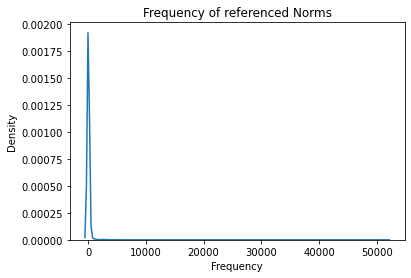

In [41]:
ax = sns.kdeplot(counts)
ax.set_title("Frequency of referenced Norms")
ax.set_xlabel("Frequency")

In [43]:
print("Min:", counts.min(), "; Max:", counts.max(), "; Average:", counts.sum()/counts.shape[0], 
      "; Median:", np.median(counts))

Min: 1 ; Max: 51599 ; Average: 78.72321241350387 ; Median: 2.0


## Keywords

In [47]:
keyword_list = []
for key in keywords:
    for s in key:
        if s is not None:
            keyword_list.append(s)

In [48]:
wordcloud = WordCloud(background_color="white", 
                      prefer_horizontal=1.0,
                      repeat=False,
                      width=4000,
                      height=4000)
wordcloud.generate(" ".join(keyword_list))

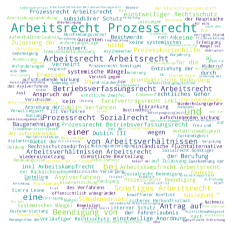

In [49]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("keywords.png")
plt.show()